## Overall Project Architecture

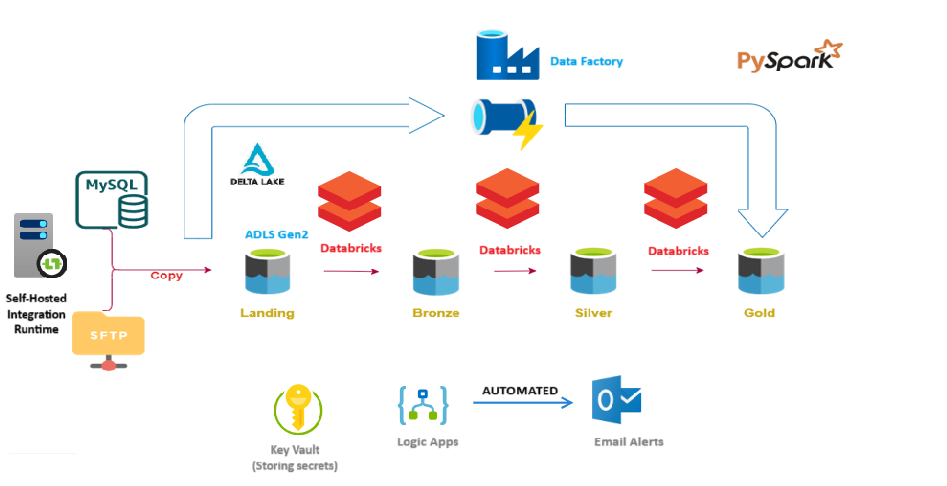

In [0]:
from IPython.display import Image, display
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/Project%20Architecture.png"))

#### 1A - MySQL to Landing Container (Extract the Data)

We now extract data from MySQL OnPrem datasource and store it into the landing container in ADLS in parquet format.

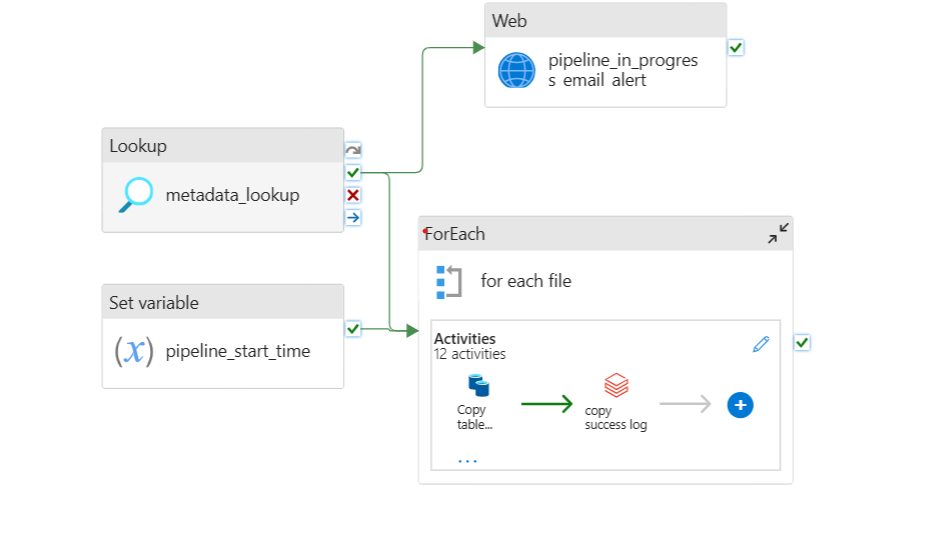

In [0]:
from IPython.display import Image, display
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/sql%20To%20Landing%20Container%201.png"))


- **Lookup Activity** - We use this activity to get relevant parameter details from delta tables so that it can be passed into the pipeline further. `LU activity Expression:`
  - `@concat('SELECT control.source_ref_id,control.job_id, control.server_name, control.port, control.database_name, control.user_name, control.secret_name, control.storage_account, control.adls_url, control.container_name, control.logic_app_url, control.email_id,param.source_file_or_table_name, param.adls_file_path, param.bronze_schema, param.bronze_tbl, param.silver_schema, param.silver_tbl, param.gold_schema, param.gold_tbl FROM ',pipeline().parameters.metadata_database,'.tbl_source_control control JOIN ',pipeline().parameters.metadata_database,'.tbl_parameters param ON control.job_id = param.job_id WHERE param.job_id = ', pipeline().parameters.job_id)`
- **Set variable** -  We use this activity to capture the start time of the pipeline dynamically whenever the pipeline runs.The output of this set variable will be used while triggering automated emails to send the the current pipeline statuses. `pipeline_start_time Expression:`
  - `@formatDateTime(convertFromUtc(utcNow(),'India Standard Time'),'yyyy-MM-dd HH:mm:ss')`
- **Web activity** - It triggers automated email stating the pipeline status `In Progress` using the **Azure Logic App**.



In [0]:
# Pipeline In progress mail Template
'''
{
    "to":"@{activity('metadata_lookup').output.value[0].email_id}",
    "subject":" @{concat('[',pipeline().globalParameters.env,']',pipeline().Pipeline,':[InProgress]')}",
    "email_body":"
   
    <!DOCTYPE html>
<html>
<body>
    Hi all,<br/>
    Please find below the status for @{pipeline().Pipeline}<br/><br/>
    
    <table>
        <tr>
            <th style='text-align: left;'>Parameters</th>
            <th style='text-align: left;'>Value</th>
        </tr>
        <tr>
            <td>JobID</td>
            <td>@{pipeline().parameters.job_id}</td>
        </tr>
        <tr>
            <td>Status</td>
            <td><span style='color:Red;background-color:yellow;'>In Progress</span></td>
        </tr>
        <tr>
            <td>Scheduled</td>
            <td>@{pipeline().TriggerType}</td>
        </tr>
        <tr>
            <td>LoadID</td>
            <td>@{pipeline().RunId}</td>
        </tr>
        <tr>
            <td>JobStart</td>
            <td>@{variables('start_time')}</td>
        </tr>
    </table><br/><br/><br/>
    
    <p>QtrEnergy Team.</p>
</body>
</html>
    "
}

'''

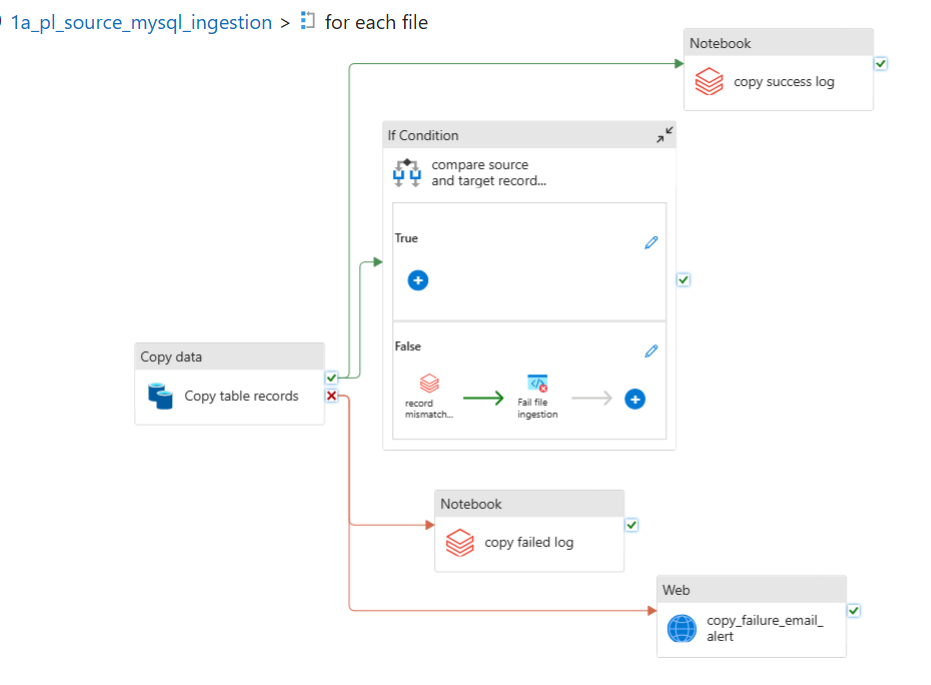

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/sql%20To%20Landing%20Container%202.png"))

- **ForEach Activity** - We use this activity to loop through each file present in the MySQL source location and perform the following:
  - Perform **COPY activity** and log the status of the copy activity into the success or failure log as per the activity result.
  - Then we add **IF activity** to compare the records between the source tables and the records inserted into the landing container. `IF Expression:`
    - `@equals(activity('Copy table records').output.rowsRead,activity('Copy table records').output.rowsCopied)`

  - If there's a mismatch between the records fetched and inserted then :
    - We Log the mismatch records status into the delta log tables through databricks dynamically.
    - We use **Fail activity** to fail the pipline execution and end it.
    - We then use **Web activity** to trigger automated email stating the pipeline status `Source File Copy Failed` using the **Azure Logic App**.
  - If the records fetched and the records inserted are equal then we carry on with further execution.

%md
#### 1B - SFTP to Landing Container (Extract the Data)

We now extract data from SFTP OnPrem datasource and store it into the landing container in ADLS in csv format.

In [0]:
from IPython.display import Image, display